# **Fine Tuning**

Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant to the specific task. It's critical to use a very low learning rate at this stage, because you are training a much larger model than in transfer learning, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates.

However, in this notebook, we are only interested in the output from the base convolutional layers of each model - which we will pass as input into a Prototypical Network. As such there will not be any classifier layers. Only the last few convolutional layers will be fine-tuned and trained as part of the Prototypical Network. The following diagram is a good representation of the fine-tuning process:

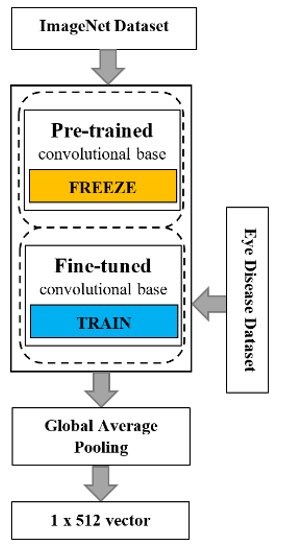

**1. Import relevant packages**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
!pip install torch-summary==1.4.4 # for DenseNet121
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd


import utilities
import read_data
import prototypical_network
import train_and_evaluation

**2. Get computational device**

In [5]:
# get the computational device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


**3. Download pre-trained model**

In [ ]:
################################# VGG19 ##############################################

#vgg19_model = models.vgg19(pretrained=True)

################################# ResNet50 ###########################################

#resnet50_model = models.resnet50(pretrained=True)

################################# DenseNet121 ########################################

densenet121_model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


**3a. Model architecture**

In [ ]:
################################# VGG19 ###############################################

#vgg19_model = vgg19_model.to(device)
#print(vgg19_model)

################################ ResNet50 #############################################

#resnet50_model = resnet50_model.to(device)
#print(resnet50_model)

################################ DenseNet121 ##########################################

densenet121_model = densenet121_model.to(device)
print(densenet121_model)

**3b. Summarize model**

In [ ]:
################################# VGG19 ########################################

#summary(vgg19_model, (3, 224, 224), device=device)

################################# ResNet50 #####################################

#summary(resnet50_model, (3, 224, 224), device=device)

################################# DenseNet121 ##################################

# you need torch-summary==1.4.4 to be able to summarize DenseNet121 model
#!pip install torch-summary==1.4.4
summary(densenet121_model, (3, 224, 244), device=device)

**4. Explore model layers and their child modules**

The following cell allows you to check out the names of the main modules that make up each model. Run one model at a time and comment out code for the other two.

In [ ]:
########################## VGG19 #############################
#for name, module in vgg19_model.named_modules():
    #print(name)

########################## ResNet50 #############################
#for name, module in resnet50_model.named_modules():
    #print(name)

########################## DenseNet121 #############################
for name, module in densenet121_model.named_modules():
    print(name)

The following 3 cells allows you to explore the layers and child modules of a model. In order to freeze and unfreeze the correct layers of a model you need to know in detail how each model architecture is laid out and the best way to access each layer.

Since the architectures are complex (e.g. the DenseNet121 model), you will need to decide what you consider as a "layer".

In [ ]:
# VGG19 --> check the names of the modules and their children
print(f"---Main modules---:")
for name, module in vgg19_model.named_children():
    print(name)

# we are interested in the features module since it contains the conv layers we want to unfreeze
print(f"---Child Modules for the 'features' module")
for name, module in vgg19_model.named_children():
    if name == "features":
        for n, m in module.named_children():
            print(n)


In [ ]:
# ResNet50 --> check the names of the module and their children
print(f"---Main modules---")
for name, module in resnet50_model.named_children():
    print(name)

# Lets say you are interested in layer4
print(f"---Child Modules for the 'layer4' module")
for name, module in resnet50_model.named_children():
    if name == "layer4":
        for n, m in module.named_children():
            print(n)

---Main modules---
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
---Child Modules for the 'layer4' module
0
1
2


In [ ]:
# DenseNet121 --> check names of modules
print(f"---Main modules---:")
for name, module in densenet121_model.named_children():
    print(name)


for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x in ["denselayer15", "denselayer16"]:
                        for param in y.parameters():
                            print(x, y)

---Main modules---:
features
classifier
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=

**5. Freeze all the layers of the model**

In the following cell, comment out code for models you are not using.

In [ ]:
######################### VGG19 ##############################
#for param in vgg19_model.parameters():
    #param.requires_grad = False

######################### ResNet50 ##############################
#for param in resnet50_model.parameters():
    #param.requires_grad = False

######################### DenseNet121 ##############################
for param in densenet121_model.parameters():
    param.requires_grad = False

**5a. Flatten outputs from the Convolutional base networks and remove the Linear layers**

In [ ]:
###################################### VGG19 ##########################################

#vgg19_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
#vgg19_model.classifier = nn.Flatten()
#summary(vgg19_model, (3, 224, 224), device=device)

####################################### ResNet50 ######################################

#resnet50_model.fc = nn.Flatten()
#summary(resnet50_model, (3, 224, 224), device=device)

###################################### DenseNet121 ####################################

densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)

**6. Unfreeze the layers you want for fine-tuning**

Each of the following 3 cells contains code to unfreeze 4 convolutional layers for a model. Run one cell depending on which model you are currently using.

In [ ]:
# VGG19 --> unfreeze parameters for the last 2 conv layers
# changed 28 to 34
for param in vgg19_model.features[34:].parameters():
    param.requires_grad = True

In [ ]:
# ResNet50 --> unfreeze the last bottleneck conv layers
for param in resnet50_model.layer4[2:].parameters():
    param.requires_grad = True

In [ ]:
# DenseNet121 --> unfreeze denselayer 16. It contains 2 conv layers
for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x == "denselayer16":
                        for param in y.parameters():
                            param.requires_grad = True

# also unfreeze the 'features.norm5' layers
for name, module in densenet121_model.features.named_children():
    if name == "norm5":
        for param in module.parameters():
            param.requires_grad = True


**6a. Check if the freezing & unfreezing has worked**

In the following 2 cells , change the name of the model depending on which model you are using.

In [ ]:
for param in densenet121_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

**6b. Check the number of trainable and non-trainable parameters**

Summarize the model and check the number of trainable and non-trainable parameters. You will find that since we are only training 4 base convolutional layers, the number of trainable parameters is significantly less than what you would normally have when training a full model.

In [ ]:
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

**7. Get training and validation data**

In [6]:
img_height, img_width = 224, 224 

In [7]:
%%time
# get training data
train_data_dir = utilities.train_data_dir
x_train, y_train = read_data.read_eye_images(train_data_dir, img_height, img_width, augmentation=True)

CPU times: user 622 ms, sys: 149 ms, total: 771 ms
Wall time: 42.9 s


In [ ]:
# check the shape of our data
x_train.shape, y_train.shape

In [ ]:
# get validation dataset
validation_data_dir = utilities.validation_data_dir
x_val, y_val = read_data.read_eye_images(validation_data_dir, img_height, img_width, augmentation=True)


In [ ]:
# check the shape of our data
x_val.shape, y_val.shape

((420, 224, 224, 3), (420,))

**8. Display example images**

Before running a model with any data, you should have a visual inspection of the data first.

Class labels sampled: ['cataract' 'pterygium' 'keratoconus']


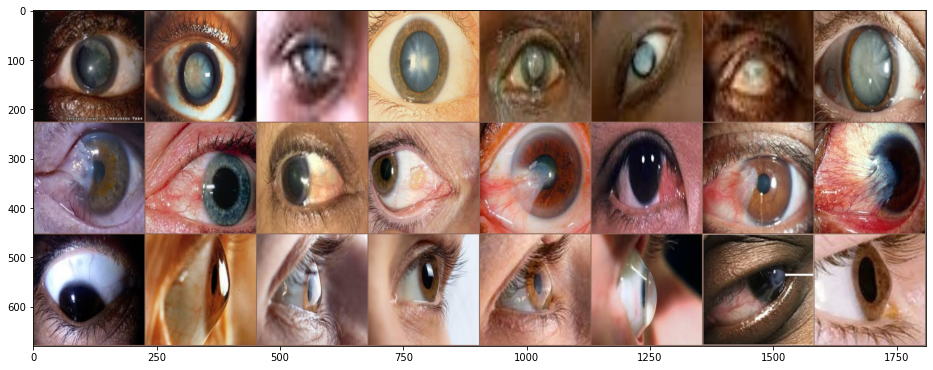

In [20]:
# As an example, lets pick a sample with the following
n_way = 3     # no. of classes --> Remember due to augmentation we now have 30 classes to sample from
n_support = 5 # no. of support images per class
n_query = 3   # no. of query images per class
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train) #  returns a dictionary
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

**9. Train a Prototypical Network using a fine-tuned base model**

In [ ]:
model = prototypical_network.ProtoNet(densenet121_model, device)
model.to(device)

# you need to use a very low learning rate
basic_learning_rate = 0.0001

# we only want to update the layers that we unfroze in the model
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       # n_way <= No. of unique classes in the validation set
n_support = 10   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

# name to save model as
filename = "DenseNet121-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

Start training: 




Epoch: 1
	Train Loss: 3.123 | Train Acc: 80.25%
	 Val. Loss: 6.016 | Val. Acc: 69.75%




Epoch: 2
	Train Loss: 2.951 | Train Acc: 81.00%
	 Val. Loss: 5.492 | Val. Acc: 70.75%




Epoch: 3
	Train Loss: 4.158 | Train Acc: 80.00%
	 Val. Loss: 5.779 | Val. Acc: 69.50%




Epoch: 4
	Train Loss: 6.446 | Train Acc: 70.50%
	 Val. Loss: 4.918 | Val. Acc: 68.25%




Epoch: 5
	Train Loss: 4.614 | Train Acc: 77.25%
	 Val. Loss: 5.211 | Val. Acc: 72.50%




Epoch: 6
	Train Loss: 2.811 | Train Acc: 81.75%
	 Val. Loss: 4.354 | Val. Acc: 72.25%




Epoch: 7
	Train Loss: 4.182 | Train Acc: 79.25%
	 Val. Loss: 7.752 | Val. Acc: 67.75%




Epoch: 8
	Train Loss: 4.927 | Train Acc: 76.50%
	 Val. Loss: 4.336 | Val. Acc: 72.50%




Epoch: 9
	Train Loss: 4.238 | Train Acc: 77.50%
	 Val. Loss: 5.540 | Val. Acc: 70.75%




Epoch: 10
	Train Loss: 2.800 | Train Acc: 84.00%
	 Val. Loss: 5.772 | Val. Acc: 67.25%




Epoch: 11
	Train Loss: 4.251 | Train Acc: 75.75%
	 Val. Loss: 5.056 | Val. Acc: 71.50%




Epoch: 12
	Train Loss: 4.281 | Train Acc: 78.00%
	 Val. Loss: 4.850 | Val. Acc: 71.25%




Epoch: 13
	Train Loss: 5.014 | Train Acc: 75.25%
	 Val. Loss: 5.073 | Val. Acc: 71.50%




Epoch: 14
	Train Loss: 3.301 | Train Acc: 82.75%
	 Val. Loss: 5.875 | Val. Acc: 67.75%




Epoch: 15
	Train Loss: 3.956 | Train Acc: 79.00%
	 Val. Loss: 4.462 | Val. Acc: 73.00%




Epoch: 16
	Train Loss: 4.259 | Train Acc: 78.50%
	 Val. Loss: 4.516 | Val. Acc: 74.00%




Epoch: 17
	Train Loss: 5.685 | Train Acc: 75.00%
	 Val. Loss: 5.001 | Val. Acc: 72.50%




Epoch: 18
	Train Loss: 4.317 | Train Acc: 77.00%
	 Val. Loss: 4.697 | Val. Acc: 73.00%




Epoch: 19
	Train Loss: 3.068 | Train Acc: 80.50%
	 Val. Loss: 6.402 | Val. Acc: 69.50%




Epoch: 20
	Train Loss: 3.854 | Train Acc: 74.50%
	 Val. Loss: 5.602 | Val. Acc: 73.75%


**9b. Display Accuracy and Loss values**

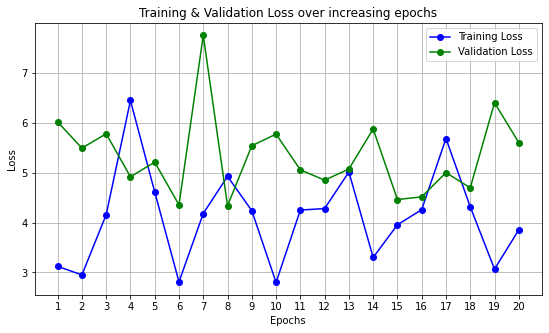

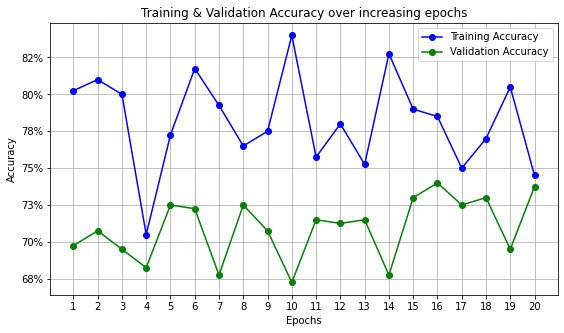

In [ ]:
epochs = np.arange(max_epoch) + 1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Training & Validation Loss over increasing epochs')
plt.plot(epochs, train_loss_list,'bo-', label='Training Loss')
plt.plot(epochs, validation_loss_list,'go-', label='Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(122)
plt.title('Training & Validation Accuracy over increasing epochs')
plt.plot(epochs, train_accuracy_list, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_list, 'go-', label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

**10. Save results to CSV file**

In [ ]:
d = []

# loop through loss and accuracy values
for epoch, (train_loss, validation_loss, train_acc, validation_acc) in enumerate(zip(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list)):
  
  d.append({"Epoch": epoch, "Training_Loss": train_loss, "Validation_loss": validation_loss, "Training_Acc": train_acc, "Validation_Acc": validation_acc})

In [ ]:
temp_dataframe = pd.DataFrame(d)
temp_dataframe.head()

,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,4.675041,5.577668,0.7800,0.7000
1,1,5.892724,3.274374,0.7225,0.7675
2,2,4.907463,4.992544,0.7875,0.7000
3,3,3.045144,3.695411,0.8100,0.7475
4,4,4.199113,5.706000,0.7425,0.7150


In [ ]:
# save Dataframe to CSV file
temp_dataframe.to_csv('DenseNet121-Acc-Loss.csv')

**11. Plot Loss and Accuracy for all models on one graph**

In [ ]:
# read csv files into a pandas dataframes
VGG19_dataframe = pd.read_csv("/content/drive/MyDrive/Eyes_Diseases/VGG19-Acc-Loss.csv")

ResNet50_dataframe = pd.read_csv("/content/drive/MyDrive/Eyes_Diseases/ResNet50-Acc-Loss.csv")

DenseNet121_dataframe = pd.read_csv("/content/drive/MyDrive/Eyes_Diseases/DenseNet121-Acc-Loss.csv")

In [ ]:
# display the first 5 rows to make sure we have uploaded our data correctly
VGG19_dataframe.head()

,Unnamed: 0,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,0,0.193202,0.397446,0.9200,0.8200
1,1,1,0.324606,0.372075,0.8275,0.8200
2,2,2,0.214434,0.431174,0.8950,0.8025
3,3,3,0.370715,0.298670,0.8450,0.8700
4,4,4,0.123368,0.488782,0.9575,0.7750


In [ ]:
ResNet50_dataframe.head()

,Unnamed: 0,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,0,3.555915,3.740771,0.7800,0.7350
1,1,1,3.493483,3.339938,0.8050,0.7625
2,2,2,3.075996,5.951447,0.8050,0.5925
3,3,3,2.768057,6.302925,0.8125,0.6575
4,4,4,5.734345,4.668066,0.6700,0.6875


In [ ]:
DenseNet121_dataframe.head()

,Unnamed: 0,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,0,4.675041,5.577668,0.7800,0.7000
1,1,1,5.892724,3.274374,0.7225,0.7675
2,2,2,4.907463,4.992544,0.7875,0.7000
3,3,3,3.045144,3.695411,0.8100,0.7475
4,4,4,4.199113,5.706000,0.7425,0.7150


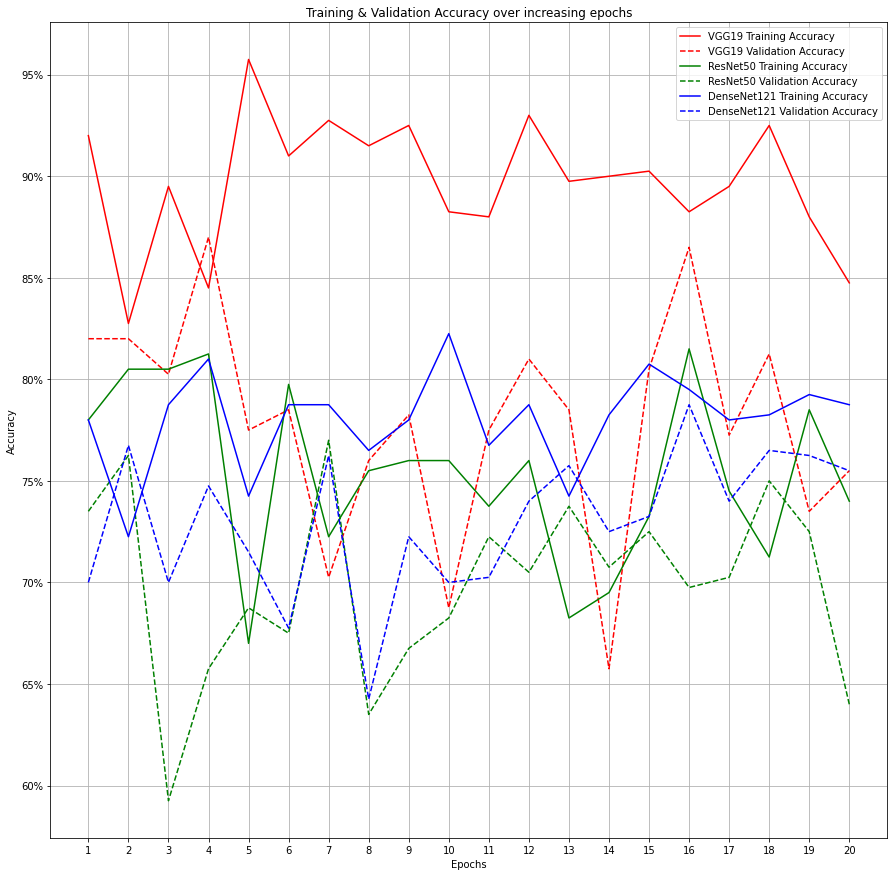

In [ ]:
epochs = np.arange(20) + 1
plt.figure(figsize=(15, 15))
#plt.subplot(122)
plt.title('Training & Validation Accuracy over increasing epochs')
plt.plot(epochs, VGG19_dataframe["Training_Acc"].tolist(), 'r-', label='VGG19 Training Accuracy')
plt.plot(epochs, VGG19_dataframe["Validation_Acc"].tolist(), 'r--', label='VGG19 Validation Accuracy')
plt.plot(epochs, ResNet50_dataframe["Training_Acc"].tolist(), 'g-', label='ResNet50 Training Accuracy')
plt.plot(epochs, ResNet50_dataframe["Validation_Acc"].tolist(), 'g--', label='ResNet50 Validation Accuracy')
plt.plot(epochs, DenseNet121_dataframe["Training_Acc"].tolist(), 'b-', label='DenseNet121 Training Accuracy')
plt.plot(epochs, DenseNet121_dataframe["Validation_Acc"].tolist(), 'b--', label='DenseNet121 Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

Analysis of the Figure above shows that the Prototypical Network using the VGG19 model overfit the data. This is also true when using the ResNet50 model as the feature extractor - although it's to a lesser extent. This is a sign of a Prototypical Network which has memorized the training data and is struggling to generalize and there accurately predict of the validation dataset whose features it did not encounter during training. Interestingly, using the DenseNet121 model, it seem there is some overfitting up to the 13th epoch. After that there is some consistence in the model when it comes to the training and validation accuracies.

Consequently, we will drop the VGG19 and ResNet50 models and only use Prototypical Network with the DenseNet121 model to test our data.

**12. Test the Prototypical Network**

In [ ]:
%%time
# we want to resize all our images to 224x224
img_height, img_width = 224, 224
data_dir = utilities.test_data_dir
x_test, y_test = read_data.read_eye_images(data_dir, img_height, img_width, augmentation=False)

CPU times: user 391 ms, sys: 56.5 ms, total: 448 ms
Wall time: 38 s


In [ ]:
# check the shape of our data
x_test.shape, y_test.shape

((90, 224, 224, 3), (90,))

In [ ]:
# Lets test our Prototypical Network Model 

prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 1
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 23.585, Accuracy: 0.67
Episode: 100 ---> Loss: 29.099, Accuracy: 0.50
Episode: 200 ---> Loss: 14.003, Accuracy: 0.70
Episode: 300 ---> Loss: 11.680, Accuracy: 0.77
Episode: 400 ---> Loss: 5.489, Accuracy: 0.83
Episode: 500 ---> Loss: 6.747, Accuracy: 0.83
Episode: 600 ---> Loss: 9.055, Accuracy: 0.83
Episode: 700 ---> Loss: 21.267, Accuracy: 0.50
Episode: 800 ---> Loss: 13.535, Accuracy: 0.77
Episode: 900 ---> Loss: 27.107, Accuracy: 0.53
Episode: 1000 ---> Loss: 6.291, Accuracy: 0.83
Episode: 1100 ---> Loss: 11.525, Accuracy: 0.80
Episode: 1200 ---> Loss: 16.235, Accuracy: 0.80
Episode: 1300 ---> Loss: 15.029, Accuracy: 0.73
Episode: 1400 ---> Loss: 16.437, Accuracy: 0.67
Episode: 1500 ---> Loss: 7.689, Accuracy: 0.87
Episode: 1600 ---> Loss: 52.031, Accuracy: 0.60
Episode: 1700 ---> Loss: 31.562, Accuracy: 0.73
Episode: 1800 ---> Loss: 37.166, Accuracy: 0.47
Episode: 1900 ---> Loss: 20.034, Accuracy: 0.80
Episode: 2000

**13. Make predictions**

Class labels sampled: ['pink_eye' 'strabismus' 'trachoma']
{'loss': 11.285049438476562, 'acc': 0.7666667103767395, 'y_hat': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 2, 0, 2, 0, 0, 2, 0, 0, 0]], device='cuda:0')}


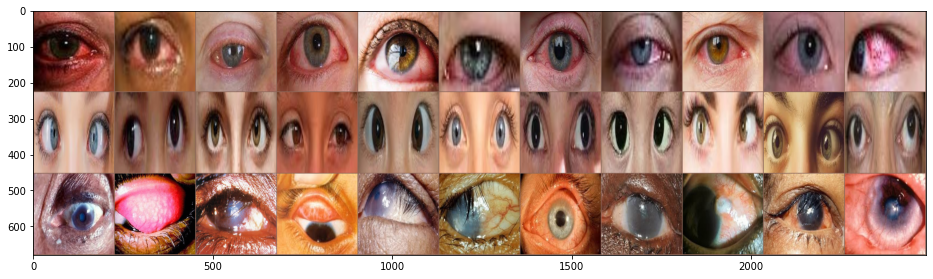

In [ ]:
# Lets ask our model to predict on (n_query) tasks

prototypical_model.to(device)
n_way = 3
n_support = 1
n_query = 10 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

# display the sample images used
train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")


# display the test results
print(results)